In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import sys
sys.path.append('../')

from torchvision.datasets import Cityscapes
from src.wilddashdataset import WilddashDataset2
from torchvision.transforms.v2 import (
    Compose,
    Normalize,
    Resize,
    ToImage,
    ToDtype,
)
import matplotlib.pyplot as plt

transform = Compose([
        ToImage(),
        Resize((224, 224)),
        ToDtype(torch.float32, scale=True),
        Normalize((0.5,), (0.5,)),
    ])
target_transform = Compose([
        ToImage(),
        Resize((224, 224)),
    ])

In [2]:

def plot_img(img1, img2):
    img1_np = img1.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img2_np = img2.permute(1, 2, 0).numpy() if img2.shape[0] > 1 else img2.squeeze(0).numpy()

    # Plot the image and label
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img1_np)
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(img2_np)  # Use cmap="gray" for single-channel
    ax[1].set_title("Label")
    ax[1].axis("off")

    plt.show()

In [3]:
# Load the dataset and make a split for training and validation
train_cityscapes_dataset = Cityscapes(
    "../data/cityscapes", 
    split="train", 
    mode="fine", 
    target_type="semantic", 
    transform=transform,
    target_transform=target_transform,
)
valid_cityscapes_dataset = Cityscapes(
    "../data/cityscapes", 
    split="val", 
    mode="fine", 
    target_type="semantic", 
    transform=transform, 
    target_transform=target_transform,
)

In [4]:
print(f"cls len {len(Cityscapes.classes)}")
for cls in Cityscapes.classes:
    if cls.train_id != 255:
        x = [(x/255 - 0.5) / 0.5 for x in cls.color]
        x = sum(x) / len(x)
        print(f"{cls.train_id}: {cls.color} => {cls.name}=> {x}")

cls len 35
0: (128, 64, 128) => road=> -0.16339869281045752
1: (244, 35, 232) => sidewalk=> 0.3359477124183006
2: (70, 70, 70) => building=> -0.4509803921568627
3: (102, 102, 156) => wall=> -0.05882352941176464
4: (190, 153, 153) => fence=> 0.29673202614379085
5: (153, 153, 153) => pole=> 0.19999999999999996
6: (250, 170, 30) => traffic light=> 0.17647058823529407
7: (220, 220, 0) => traffic sign=> 0.15032679738562096
8: (107, 142, 35) => vegetation=> -0.257516339869281
9: (152, 251, 152) => terrain=> 0.4509803921568627
10: (70, 130, 180) => sky=> -0.006535947712418277
11: (220, 20, 60) => person=> -0.2156862745098039
12: (255, 0, 0) => rider=> -0.3333333333333333
13: (0, 0, 142) => car=> -0.6287581699346405
14: (0, 0, 70) => truck=> -0.8169934640522877
15: (0, 60, 100) => bus=> -0.5816993464052288
16: (0, 80, 100) => train=> -0.5294117647058824
17: (0, 0, 230) => motorcycle=> -0.3986928104575163
18: (119, 11, 32) => bicycle=> -0.5764705882352942
-1: (0, 0, 142) => license plate=> -0.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


Cityscapes Image Shape: torch.Size([3, 224, 224])
Cityscapes Label Shape: torch.Size([1, 224, 224])
Unique class indices in the label: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26], dtype=torch.uint8)


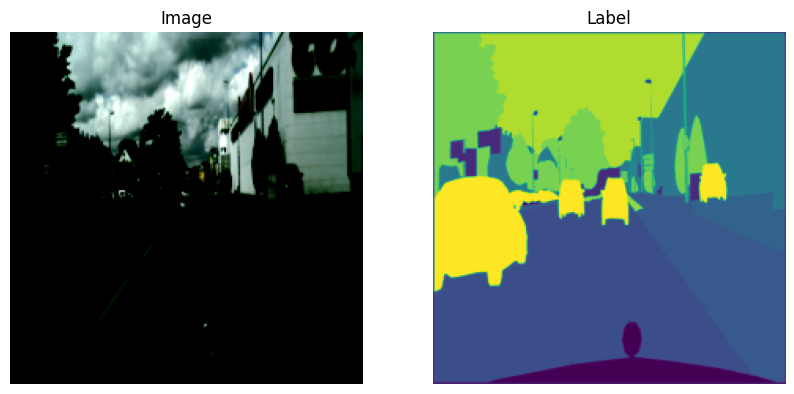

In [5]:
# Get the first sample from each dataset
image1, label1 = valid_cityscapes_dataset[0]

# Print sizes
print("Cityscapes Image Shape:", image1.shape)
print("Cityscapes Label Shape:", label1.shape)


label_np = label1.long().squeeze(0).numpy()
unique_classes = torch.unique(label1)
print("Unique class indices in the label:", unique_classes)
plot_img(image1, label1)

In [6]:
train_wilddash_dataset = WilddashDataset2(
    "../data/wilddash2", 
    split="train",
    target_type="semantic",
    transform=transform, 
    target_transform=target_transform,
)
valid_wilddash_dataset = WilddashDataset2(
    "../data/wilddash2", 
    split="val",
    target_type="semantic",
    transform=transform, 
    target_transform=target_transform,
)

In [7]:
from collections import defaultdict

# Mapping class IDs to train IDs
id_to_trainid = defaultdict(lambda: 255, {cls.id: cls.train_id for cls in Cityscapes.classes})
def convert_to_train_id(label_img: torch.Tensor) -> torch.Tensor:
    return label_img.apply_(lambda x: id_to_trainid[x])


def convert_train_id_to_color(prediction: torch.Tensor) -> torch.Tensor:
    train_id_to_color = {cls.train_id: cls.color for cls in Cityscapes.classes if cls.train_id != 255}
    train_id_to_color[255] = (0, 0, 0)  # Assign black to ignored labels
    batch, _, height, width = prediction.shape
    color_image = torch.zeros((batch, 3, height, width), dtype=torch.uint8)

    for train_id, color in train_id_to_color.items():
        mask = prediction == train_id
        print(mask.shape)
        for i in range(3):
            color_image[:, i][mask.squeeze(0)] = color[i]

    return color_image


Cityscapes Image Shape: torch.Size([1, 224, 224])
Cityscapes Label Shape: torch.Size([1, 224, 224])
Unique class indices in the label: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 39, 43, 45, 47, 53, 54], dtype=torch.uint8)
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.S

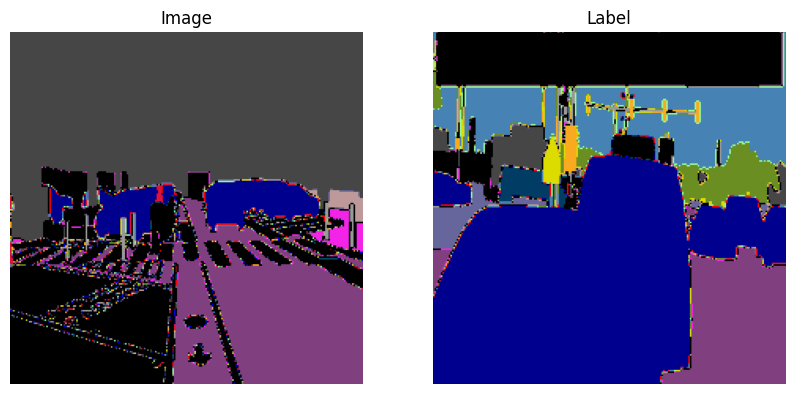

In [9]:
# Get the first sample from each dataset

image1, label1 = train_wilddash_dataset[1]
image2, label2 = valid_wilddash_dataset[2]

# Print sizes
print("Cityscapes Image Shape:", label1.shape)
print("Cityscapes Label Shape:", label2.shape)

label_np = label2.squeeze(0).numpy()
unique_classes = torch.unique(label2)
print("Unique class indices in the label:", unique_classes)

# print(label2)
label1 = label1.unsqueeze(1)
label2 = label2.unsqueeze(1)
label1 = convert_to_train_id(label1)
label2 = convert_to_train_id(label2)
# print(label2)
label1 = convert_train_id_to_color(label1)
label2 = convert_train_id_to_color(label2)

# print(label2)
print(f"output label1 : {label1.shape}")
print(f"output label2 : {label2.shape}")

label1 = label1.squeeze(0)
label2 = label2.squeeze(0)
print(f"output label2 : {label2.shape}")

plot_img(label1, label2)